<a href="https://colab.research.google.com/github/YemmyMMU/Computer-Vision-and-Graphics/blob/master/rotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 114)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 64)                7360      
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_29 (Dense)             (None, 7)                 455       
Total params: 11,975
Trainable params: 11,975
Non-trainable params: 0
_________________________________________________________________
(10000, 38, 3)
(10000, 7)
Training 5% complete. Training loss: 0.9852751889228821 | Validation loss: 0.9604950528144837
Training 10% complete. Training loss: 0.5241179845929146 | Validation loss: 0.5710167663097382
Training 15% complete. Training l

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

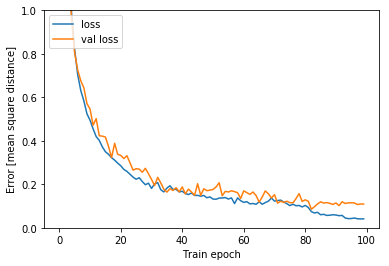

In [10]:
!pip install tensorflow_graphics

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow_graphics.geometry.transformation import quaternion
from tensorflow_graphics.math import vector
from tensorflow_graphics.notebooks import threejs_visualization
from tensorflow_graphics.notebooks.resources import tfg_simplified_logo

tf.enable_eager_execution()

# Loads the Tensorflow Graphics simplified logo.
vertices = tfg_simplified_logo.mesh['vertices'].astype(np.float32)
faces = tfg_simplified_logo.mesh['faces']
num_vertices = vertices.shape[0]

# Constructs the model.
model = keras.Sequential()
model.add(layers.Flatten(input_shape=(num_vertices, 3)))
model.add(layers.Dense(64, activation=tf.nn.tanh))
model.add(layers.Dense(64, activation=tf.nn.relu))
model.add(layers.Dense(7))


def pose_estimation_loss(y_true, y_pred):
  """Pose estimation loss used for training.

  This loss measures the average of squared distance between some vertices
  of the mesh in 'rest pose' and the transformed mesh to which the predicted
  inverse pose is applied. Comparing this loss with a regular L2 loss on the
  quaternion and translation values is left as exercise to the interested
  reader.

  Args:
    y_true: The ground-truth value.
    y_pred: The prediction we want to evaluate the loss for.

  Returns:
    A scalar value containing the loss described in the description above.
  """
  # y_true.shape : (batch, 7)
  y_true_q, y_true_t = tf.split(y_true, (4, 3), axis=-1)
  # y_pred.shape : (batch, 7)
  y_pred_q, y_pred_t = tf.split(y_pred, (4, 3), axis=-1)

  # vertices.shape: (num_vertices, 3)
  # corners.shape:(num_vertices, 1, 3)
  corners = tf.expand_dims(vertices, axis=1)

  # transformed_corners.shape: (num_vertices, batch, 3)
  # q and t shapes get pre-pre-padded with 1's following standard broadcast rules.
  transformed_corners = quaternion.rotate(corners, y_pred_q) + y_pred_t

  # recovered_corners.shape: (num_vertices, batch, 3)
  recovered_corners = quaternion.rotate(transformed_corners - y_true_t,
                                        quaternion.inverse(y_true_q))

  # vertex_error.shape: (num_vertices, batch)
  vertex_error = tf.reduce_sum((recovered_corners - corners)**2, axis=-1)

  return tf.reduce_mean(vertex_error)


optimizer = keras.optimizers.Adam()
model.compile(loss=pose_estimation_loss, optimizer=optimizer)
model.summary()


def generate_training_data(num_samples):
  # random_angles.shape: (num_samples, 3)
  random_angles = np.random.uniform(-np.pi, np.pi,
                                    (num_samples, 3)).astype(np.float32)

  # random_quaternion.shape: (num_samples, 4)
  random_quaternion = quaternion.from_euler(random_angles)

  # random_translation.shape: (num_samples, 3)
  random_translation = np.random.uniform(-2.0, 2.0,
                                         (num_samples, 3)).astype(np.float32)

  # data.shape : (num_samples, num_vertices, 3)
  data = quaternion.rotate(vertices[tf.newaxis, :, :],
                           random_quaternion[:, tf.newaxis, :]
                          ) + random_translation[:, tf.newaxis, :]

  # target.shape : (num_samples, 4+3)
  target = tf.concat((random_quaternion, random_translation), axis=-1)

  return np.array(data), np.array(target)

num_samples = 10000

data, target = generate_training_data(num_samples)

print(data.shape)   # (num_samples, num_vertices, 3): the vertices
print(target.shape)  # (num_samples, 4+3): the quaternion and translation


# Callback allowing to display the progression of the training task.
class ProgressTracker(keras.callbacks.Callback):

  def __init__(self, num_epochs, step=5):
    self.num_epochs = num_epochs
    self.current_epoch = 0.
    self.step = step
    self.last_percentage_report = 0

  def on_epoch_end(self, batch, logs={}):
    self.current_epoch += 1.
    training_percentage = int(self.current_epoch * 100.0 / self.num_epochs)
    if training_percentage - self.last_percentage_report >= self.step:
      print('Training ' + str(
          training_percentage) + '% complete. Training loss: ' + str(
              logs.get('loss')) + ' | Validation loss: ' + str(
                  logs.get('val_loss')))
      self.last_percentage_report = training_percentage
      
      
reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)
    
    
# Everything is now in place to train.
EPOCHS = 100
pt = ProgressTracker(EPOCHS)
history = model.fit(
    data,
    target,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=0,
    batch_size=32,
    callbacks=[reduce_lr_callback, pt])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0, 1])
plt.legend(['loss', 'val loss'], loc='upper left')
plt.xlabel('Train epoch')
_ = plt.ylabel('Error [mean square distance]')




# Defines the loss function to be optimized.
def transform_points(target_points, quaternion_variable, translation_variable):
  return quaternion.rotate(target_points,
                           quaternion_variable) + translation_variable

class Viewer(object):

  def __init__(self, my_vertices):
    my_vertices = np.asarray(my_vertices)
    context = threejs_visualization.build_context()
    light1 = context.THREE.PointLight.new_object(0x808080)
    light1.position.set(10., 10., 10.)
    light2 = context.THREE.AmbientLight.new_object(0x808080)
    lights = (light1, light2)

    material = context.THREE.MeshLambertMaterial.new_object({
        'color': 0xfffacd,
    })

    material_deformed = context.THREE.MeshLambertMaterial.new_object({
        'color': 0xf0fff0,
    })

    camera = threejs_visualization.build_perspective_camera(
        field_of_view=30, position=(10.0, 10.0, 10.0))

    mesh = {'vertices': vertices, 'faces': faces, 'material': material}
    transformed_mesh = {
        'vertices': my_vertices,
        'faces': faces,
        'material': material_deformed
    }
    geometries = threejs_visualization.triangular_mesh_renderer(
        [mesh, transformed_mesh],
        lights=lights,
        camera=camera,
        width=400,
        height=400)

    self.geometries = geometries

  def update(self, transformed_points):
    self.geometries[1].getAttribute('position').copyArray(
        transformed_points.numpy().ravel().tolist())
    self.geometries[1].getAttribute('position').needsUpdate = True

    
def get_random_transform():
  # Forms a random translation
  with tf.name_scope('translation_variable'):
    random_translation = tf.Variable(
        np.random.uniform(-2.0, 2.0, (3,)), dtype=tf.float32)

  # Forms a random quaternion
  hi = np.pi
  lo = -hi
  random_angles = np.random.uniform(lo, hi, (3,)).astype(np.float32)
  with tf.name_scope('rotation_variable'):
    random_quaternion = tf.Variable(quaternion.from_euler(random_angles))

  return random_quaternion, random_translation


random_quaternion, random_translation = get_random_transform()

initial_orientation = transform_points(vertices, random_quaternion,
                                       random_translation).numpy()
viewer = Viewer(initial_orientation)

predicted_transformation = model.predict(initial_orientation[tf.newaxis, :, :])

predicted_inverse_q = quaternion.inverse(predicted_transformation[0, 0:4])
predicted_inverse_t = -predicted_transformation[0, 4:]

predicted_aligned = quaternion.rotate(initial_orientation + predicted_inverse_t,
                                      predicted_inverse_q)

viewer = Viewer(predicted_aligned)
    
    
 